## Understanding modality gap in a multimodal contrastive setup

This file contains the code to implement a contrastive learning based schema matching method from this [JBI paper](https://www.sciencedirect.com/science/article/pii/S1532046424000200). 


A schematic of the method is given below. 

1) Since this is an experimental setup, we will take one dataset and partition into two. 

2) The second half of the dataset is treated as a separate dataset and its columns are perturbed. 

The learning task is to correctly match the columns given information on some premapped columns. To apply CL, we treat the premapped columns as one modality and the other set of columns as another modality and exploit the association between the two sets with the assumption the first set is common betweent he two datasets. Using this example, we intend to demonstrate the existence of modality gap for the two views of each datasets before and after training. 

Additionaly, we will understand the role of contrastive loss in changing the modality gap in this setup compared to a only one dataset setup. 

In [73]:
# importing packages
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
import os
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xgboost as xgb

In [74]:
import sys
print(sys.version)

3.9.10 (main, Feb  9 2022, 00:00:00) 
[GCC 11.2.1 20220127 (Red Hat 11.2.1-9)]


In [75]:
# check the current directory, set it as Database_matching
if os.getcwd()!= '/home/trips/ContrastiveLearning_Tutorial/Database_matching':  # replace the path with your local path
    os.chdir('/home/trips/ContrastiveLearning_Tutorial/Database_matching')
print("Current working directory is : ", os.getcwd())

from utils_db_matching import *

saving_dir = '/home/trips/ContrastiveLearning_Tutorial/Database_matching/Figures/'
if not os.path.exists(saving_dir):
    os.makedirs(saving_dir)

Current working directory is :  /home/trips/ContrastiveLearning_Tutorial/Database_matching


In [76]:
# function for initial loading and processing of the dataset
def load_dataset(dataset):
    if dataset=='SD_2':
        filename = "2021-05-18Syn_Data_2_Sample_no_1_size_20_10000_for_AE_balanced.csv" 
        data_file = os.path.join('../Small_datasets', dataset, filename)
        full_Data0 = pd.read_csv(data_file)
        
    if dataset=='Nomao':
        data_file = os.path.join('../Small_datasets', dataset, dataset + ".data")

        full_Data0 = pd.read_csv(data_file, header=None)
        full_Data0.replace('?', np.nan, inplace=True)
        full_Data0 = full_Data0.loc[:, ~(full_Data0 == 'n').any()]  # dropping the nominal type columns
        full_Data0.drop(columns=[0], inplace=True)  # dropping the id column

        # drop columns with very high missing percentage
        percent_missing = full_Data0.isnull().sum() * 100 / len(full_Data0)
        missing_value_df = pd.DataFrame({'column_name': full_Data0.columns,
                                         'percent_missing': percent_missing}).sort_values(by='percent_missing')
        full_Data0 = full_Data0[missing_value_df[missing_value_df['percent_missing'] < 70.0]['column_name']]

        ## final columns that were selected including the label and excluding the first column that was the id
        ## [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 65, 66, 67, 68, 69,
        # 70, 73, 74, 75, 76, 77, 78, 81, 82, 83, 84, 85, 86, 89, 90, 91, 97, 98, 99, 101, 102, 103, 105, 106, 107, 109,
        # 110, 111, 113, 114, 115, 117, 118, 119]

        full_Data0 = full_Data0.reindex(columns=sorted(full_Data0.columns))  # reindexing so that label is at the end
        new_feature_names = ['Col' + str(i + 1) for i in range(full_Data0.shape[1] - 1)] 
        full_Data0 = full_Data0.set_axis(new_feature_names+ ['Y'], axis=1)  # renamed the continuous columns

        # converting the columns that are being treated as object type but actually are float
        for a in full_Data0.columns:
            if full_Data0[a].dtype == 'object':
                full_Data0[a] = full_Data0[a].astype('float')

        full_Data0 = full_Data0.fillna(full_Data0.mean())  # filling the missing values
    
    full_Data = full_Data0.copy()
    full_Data['Y'] = np.where(full_Data['Y'] == -1, 0, 1)  # to make it compatible with the rest    
    num_sample = full_Data.shape[0]
    num_features = full_Data.shape[1] - 1

    # full data initial correlation
    Feature_matrix = full_Data.iloc[:, :-1]
    Cor_from_df = Feature_matrix.corr()
    
    return full_Data, num_sample, num_features, Cor_from_df

In [77]:
# initial setting and the dataset choice

dataset = "Nomao" # dataset name  {'SD_2', 'Nomao'}
batchSize = 6
learningRate = 0.0004
LRPatience = 5
learningRateFactor=0.3931
dropout_rate_CL = 0.1278
epochs = 49
masking_ratio = 0.1306
tau = 0.1893
randomSeed = 784  # random seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mpfeatures = 7  # number of premapped features
outcome = 'Y'
frac_renamed = 0.5  # partition fraction two obtain two databases for which the columns would need to be matched


encKnwMapDepth = 2
encKnwMapWidth = 61
encKnwMapWidthFinal = 19

encUknwD1OrigDepth = 5
encUknwD1OrigWidth = 37
encUknwD1OrigWidthFinal = encKnwMapWidthFinal

encUknwD2ReDepth = 4
encUknwD2ReWidth = 62
encUknwD2ReWidthFinal = encKnwMapWidthFinal


### Initial preprocessing of the dataset

In [78]:
# loading data
full_data, num_sample, num_features, Cor_from_df = load_dataset(dataset)

# data dimensions 
print(" Original data size :  ", full_data.shape)  # Number of samples *  number of features

/tmp/ipykernel_3605420/2271890169.py:11: DtypeWarning: Columns (57,58,59,60,61,62,65,66,67,68,69,70,101,102,103,105,106,107,117) have mixed types. Specify dtype option on import or set low_memory=False.
  full_Data0 = pd.read_csv(data_file, header=None)


 Original data size :   (34465, 63)


In [79]:
df_train = full_data.copy()
# shuffling the mapped and unmapped
mapped_random = np.random.choice(num_features, mpfeatures, replace=False)
unmapped_random = list(set(np.arange(num_features)) - set(mapped_random))

mapped_features = ["Col" + str(i + 1) for i in mapped_random]
possible_feat_to_shuffle = ["Col" + str(i + 1) for i in unmapped_random]

print("List of mapped features", mapped_features)

# reordering to making sure that mapped features are at the starts of the vector
feature_names = mapped_features + possible_feat_to_shuffle
df_train = df_train.reindex(columns=feature_names + [outcome])


List of mapped features ['Col17', 'Col58', 'Col16', 'Col33', 'Col4', 'Col3', 'Col45']


In [80]:
# keeping a holdout sample aside
Df_for_training, Df_holdout = model_selection.train_test_split(df_train, test_size=0.1,
                                                        random_state=42,
                                                        stratify=df_train[outcome])


# splitting the holdout df into two for using in the two databases
Df_holdout_orig0, DF_holdout_r0 = model_selection.train_test_split(Df_holdout, test_size=0.5, random_state=42,stratify=Df_holdout[outcome])


df_train1, df_train2 = model_selection.train_test_split(Df_for_training, test_size=frac_renamed,
                                                        random_state=42,
                                                        stratify=Df_for_training[outcome])

print(" trial data details \n")
print("size of total train", len(df_train))
print("size of train original", len(df_train1))
print("size of train renamed", len(df_train2))

 trial data details 

size of total train 34465
size of train original 15509
size of train renamed 15509


In [81]:
""" ORIGINAL DATA PREP """
# data pre-processing normalization
normalizing_values_orig = {}
normalizing_values_orig['mean'] = df_train1[feature_names].mean(axis=0)
normalizing_values_orig['std'] = df_train1[feature_names].std(axis=0)
normalizing_values_orig['min'] = df_train1[feature_names].min(axis=0)
normalizing_values_orig['max'] = df_train1[feature_names].max(axis=0)

df_train_preproc0 = normalization(df_train1, 'mean_std', normalizing_values_orig, feature_names)
Df_holdout_orig0 = normalization(Df_holdout_orig0, 'mean_std', normalizing_values_orig, feature_names)
reordered_column_names_orig = mapped_features + [col for col in df_train_preproc0.columns if
                                                 col not in mapped_features + [outcome]] + [outcome]
df_train_preproc0 = df_train_preproc0.reindex(columns=reordered_column_names_orig)
Df_holdout_orig0 = Df_holdout_orig0.reindex(columns=reordered_column_names_orig)

""" SHUFFLED FEATURES DATA PREP """
feature_names_r = feature_names

# data preprocessing
normalizing_values_r = {}
normalizing_values_r['mean'] = df_train2[feature_names_r].mean(axis=0)
normalizing_values_r['std'] = df_train2[feature_names_r].std(axis=0)
normalizing_values_r['min'] = df_train2[feature_names_r].min(axis=0)
normalizing_values_r['max'] = df_train2[feature_names_r].max(axis=0)

df_rename_preproc0 = normalization(df_train2, 'mean_std', normalizing_values_r, feature_names_r)
DF_holdout_r0 = normalization(DF_holdout_r0, 'mean_std', normalizing_values_r, feature_names_r)

# maximum possible mistakes for this trial
max_mistakes = len(feature_names) - len(mapped_features)

### Artificial perturbation of the columns and partition into two datasets

In [82]:
df_train_preproc = df_train_preproc0.copy()
df_rename_preproc = df_rename_preproc0.copy()  # a copy to keep the original ordering as a baseline when matching
DF_holdout_r = DF_holdout_r0.copy()
Df_holdout_orig = Df_holdout_orig0.copy()

In [83]:
# reordering the features (PERMUTATION)
reorder_feat = possible_feat_to_shuffle.copy()
random.shuffle(reorder_feat)
index_for_mapping_orig_to_rename = [reorder_feat.index(num) + len(mapped_features) + 1 for num
                                    in
                                    [col for col in df_train_preproc.columns if
                                     col not in mapped_features + [outcome]]]
index_for_mapping_rename_to_orig = [[col for col in df_train_preproc.columns if
                                     col not in mapped_features + [outcome]].index(num) + len(
    mapped_features) + 1 for num in reorder_feat]

# adding index variables for the mapped variables at the start of the list
index_for_mapping_orig_to_rename = list(
    np.arange(1, mpfeatures + 1)) + index_for_mapping_orig_to_rename
index_for_mapping_rename_to_orig = list(
    np.arange(1, mpfeatures + 1)) + index_for_mapping_rename_to_orig
print(" Index for mapping orig to rename ", index_for_mapping_orig_to_rename)
print(" Index for mapping rename to original ", index_for_mapping_rename_to_orig)

reordered_column_names_r = mapped_features + reorder_feat + [outcome]
df_rename_preproc = df_rename_preproc.reindex(columns=reordered_column_names_r)
DF_holdout_r = DF_holdout_r.reindex(columns=reordered_column_names_r)


print("\n \n ------  Ordering of variables when # of mapped features is ", mpfeatures, "\n ")
print(" Original dataset \n ", reordered_column_names_orig)
print(" Permuted features dataset \n", reordered_column_names_r)

# printing the permutation matrix
P_x1 = np.zeros((len(reordered_column_names_orig), len(reordered_column_names_r)))

for i in range(len(reordered_column_names_orig)):
    for j in range(len(reordered_column_names_r)):
        if reordered_column_names_orig[i] == reordered_column_names_r[j]:
            P_x1[i,j]=1

 Index for mapping orig to rename  [1, 2, 3, 4, 5, 6, 7, 60, 15, 53, 39, 29, 34, 48, 14, 50, 37, 35, 56, 12, 59, 43, 55, 45, 28, 52, 31, 30, 36, 20, 8, 61, 58, 25, 16, 23, 49, 13, 40, 19, 62, 46, 41, 27, 51, 47, 57, 44, 21, 33, 42, 9, 17, 54, 38, 26, 11, 32, 22, 18, 10, 24]
 Index for mapping rename to original  [1, 2, 3, 4, 5, 6, 7, 31, 52, 61, 57, 20, 38, 15, 9, 35, 53, 60, 40, 30, 49, 59, 36, 62, 34, 56, 44, 25, 12, 28, 27, 58, 50, 13, 18, 29, 17, 55, 11, 39, 43, 51, 22, 48, 24, 42, 46, 14, 37, 16, 45, 26, 10, 54, 23, 19, 47, 33, 21, 8, 32, 41]

 
 ------  Ordering of variables when # of mapped features is  7 
 
 Original dataset 
  ['Col17', 'Col58', 'Col16', 'Col33', 'Col4', 'Col3', 'Col45', 'Col1', 'Col2', 'Col5', 'Col6', 'Col7', 'Col8', 'Col9', 'Col10', 'Col11', 'Col12', 'Col13', 'Col14', 'Col15', 'Col18', 'Col19', 'Col20', 'Col21', 'Col22', 'Col23', 'Col24', 'Col25', 'Col26', 'Col27', 'Col28', 'Col29', 'Col30', 'Col31', 'Col32', 'Col34', 'Col35', 'Col36', 'Col37', 'Col38', 'Col

### Training prep

In [84]:
num_NonCat_features_orig = len(reordered_column_names_orig) - 1
num_NonCat_features_r = len(reordered_column_names_r) - 1

#explicitly setting the nworkers in the dataloader was incompatible with the jupyter kernel
dataset_orig = TabularDataset(data=df_train_preproc, output_col=outcome)
train_loader_orig = DataLoader(dataset_orig, batchSize, shuffle=True)
dataset_orig_val = TabularDataset(data=Df_holdout_orig, output_col=outcome)
val_loader_orig = DataLoader(dataset_orig_val, batchSize, shuffle=True)

dataset_r = TabularDataset(data=df_rename_preproc, output_col=outcome)
train_loader_r = DataLoader(dataset_r, batchSize, shuffle=True)
dataset_r_val = TabularDataset(data=DF_holdout_r, output_col=outcome)
val_loader_r = DataLoader(dataset_r_val, batchSize, shuffle=True)

In [85]:
known_features_encoder = AE_CL(input_shape=mpfeatures, hidden_units_final=encKnwMapWidthFinal,
                                              hidden_depth=encKnwMapDepth,
                                              hidden_units=encKnwMapWidth,drop_out_p=dropout_rate_CL).to(device)
unknown_features_encoder_orig = AE_CL(input_shape=num_NonCat_features_orig - mpfeatures, hidden_units_final=encUknwD1OrigWidthFinal,
                                              hidden_depth=encUknwD1OrigDepth,
                                              hidden_units=encUknwD1OrigWidth,drop_out_p=dropout_rate_CL).to(device)
unknown_features_encoder_r = AE_CL(input_shape=num_NonCat_features_r - mpfeatures, hidden_units_final=encUknwD2ReWidthFinal,
                                              hidden_depth=encUknwD2ReDepth,
                                              hidden_units=encUknwD2ReWidth,drop_out_p=dropout_rate_CL).to(device)

withinCL_options = {'batch_size': batchSize, "tau": tau, "device": device, "cosine_similarity": True}
aug_loss = JointLoss(withinCL_options)

# breakpoint()
# create an optimizer object
optimizer_known = optim.Adam(known_features_encoder.parameters(), lr=learningRate, weight_decay=1e-5)
optimizer_unk_orig = optim.Adam(unknown_features_encoder_orig.parameters(), lr=learningRate, weight_decay=1e-5)
optimizer_unk_r = optim.Adam(unknown_features_encoder_r.parameters(), lr=learningRate, weight_decay=1e-5)

# lr scheduler
scheduler_known = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_known, patience=LRPatience, verbose=True)
scheduler_unk_orig = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_unk_orig, patience=LRPatience, verbose=True)
scheduler_unk_r = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_unk_r, patience=LRPatience, verbose=True)

### Existence of modality gap in the two datasets with two modalities as known and unknown columns

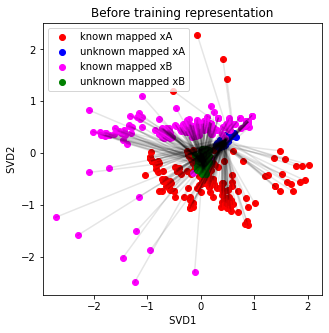

In [86]:
# Debugging to see where the embedding are positioned in the latent space
rep_known_val_o_b = known_features_encoder(
    torch.Tensor(Df_holdout_orig.iloc[:, :mpfeatures].values).to(device))
rep_unknown_val_o_b = unknown_features_encoder_orig(
    torch.Tensor(Df_holdout_orig.iloc[:, mpfeatures:-1].values).to(device))

rep_known_val_r_b = known_features_encoder(torch.Tensor(DF_holdout_r.iloc[:, :mpfeatures].values).to(device))
rep_unknown_val_r_b = unknown_features_encoder_r(
    torch.Tensor(DF_holdout_r.iloc[:, mpfeatures:-1].values).to(device))

# before training
points_to_plot = 200  # len(rep_known_val_o.cpu().detach().numpy())
features_2d_o = svd(np.concatenate([rep_known_val_o_b.cpu().detach().numpy()[:points_to_plot],
                                    rep_unknown_val_o_b.cpu().detach().numpy()[:points_to_plot]], 0))
features_2d_r = svd(np.concatenate([rep_known_val_r_b.cpu().detach().numpy()[:points_to_plot],
                                    rep_unknown_val_r_b.cpu().detach().numpy()[:points_to_plot]], 0))

plt.figure(figsize=(5, 5))
plt.scatter(features_2d_o[:-points_to_plot, 0], features_2d_o[:-points_to_plot, 1], label='known mapped xA',  c='red')  # known mapped
plt.scatter(features_2d_o[-points_to_plot:, 0], features_2d_o[-points_to_plot:, 1], label='unknown mapped xA', c='blue')  # unknown x1
plt.scatter(features_2d_r[:-points_to_plot, 0], features_2d_r[:-points_to_plot, 1], label='known mapped xB', c='magenta')  # known mapped
plt.scatter(features_2d_r[-points_to_plot:, 0], features_2d_r[-points_to_plot:, 1], label='unknown mapped xB', c='green')  # unknown x2
# connect the dots
for i in range(points_to_plot):
    plt.plot([features_2d_o[i, 0], features_2d_o[points_to_plot + i, 0]],
             [features_2d_o[i, 1], features_2d_o[points_to_plot + i, 1]], c='black', alpha=0.1)
    plt.plot([features_2d_r[i, 0], features_2d_r[points_to_plot + i, 0]],
             [features_2d_r[i, 1], features_2d_r[points_to_plot + i, 1]], c='black', alpha=0.1)
plt.xlabel(" SVD1 ")
plt.ylabel(" SVD2 ")
plt.title("Before training representation")
plt.legend()
plt.show()

In [87]:
plt.savefig(
    saving_dir +  "/Before_training_Comp_ModalityGapSVD_Dataset_" + str(dataset) + "X_o_dim_" + str(
        encKnwMapWidthFinal) + "_tau_" + str(tau) + "_mapped_features_" + str(mpfeatures) + "_#datapoints_" + str(
        points_to_plot) + "_epochs_" + str(epochs) +  ".png")
plt.savefig(
    saving_dir + "/Before_training_Comp_ModalityGapSVD_Dataset_" + str(dataset) + "X_o_dim_" + str(
        encKnwMapWidthFinal) + "_tau_" + str(tau) + "_mapped_features_" + str(mpfeatures) + "_#datapoints_" + str(
        points_to_plot) + "_epochs_" + str(epochs) +  ".pdf")
plt.close()

### Simultaneous training using the contrastive objective

In [88]:
total_loss = []
for epoch in range(epochs):
  loss_tr_o = 0
  loss_tr_r = 0
  rank_tr_o = 0
  rank_tr_r = 0
  counting_flag_for_rank = 0
  # computing the representations from the trained encoders
  known_features_encoder.train()
  unknown_features_encoder_orig.train()
  unknown_features_encoder_r.train()

  for i, data in enumerate(zip(train_loader_orig, train_loader_r)):
    if (len(data[0][1]) == len(data[1][1])) & (data[0][1].shape[0] == batchSize):
      # seperate the known and unknown features here  for passing to their corresponding encoders
      x_kn_o = data[0][1][:, :mpfeatures].to(device)
      x_kn_r = data[1][1][:, :mpfeatures].to(device)
      x_unkn_o = data[0][1][:, mpfeatures:].to(device)
      x_unkn_r = data[1][1][:, mpfeatures:].to(device)

      # reset the gradients back to zero
      # PyTorch accumulates gradients on subsequent backward passes
      optimizer_known.zero_grad()
      optimizer_unk_orig.zero_grad()
      optimizer_unk_r.zero_grad()

      datalist = [x_kn_o, x_kn_r, x_unkn_o, x_unkn_r]  # this step could be avoided

      if True:  # adding self augmentation
        for dt in range(4):
          x_bar = datalist[dt]
          x_bar_noisy = generate_noisy_xbar(x_bar)
          # Generate binary mask
          mask = torch.tensor(np.random.binomial(1, masking_ratio, x_bar.shape)).to(device)
          mask1 = torch.tensor(np.random.binomial(1, masking_ratio, x_bar.shape)).to(device)
          # breakpoint()
          # Replace selected x_bar features with the noisy ones
          x_bar = x_bar * (1 - mask) + x_bar_noisy * mask
          x_bar1 = x_bar * (1 - mask1) + x_bar_noisy * mask1

          # datalist[dt] = torch.concat((datalist[dt], x_bar), axis=0)
          datalist[dt] = torch.concat((x_bar1, x_bar), axis=0)

      # computing the encoded values
      known_rep_o = known_features_encoder(datalist[0])
      # print("passed known train encoder")
      known_rep_r = known_features_encoder(datalist[1])
      unknown_rep_o = unknown_features_encoder_orig(datalist[2])
      # print("passed unknown O train encoder")
      unknown_rep_r = unknown_features_encoder_r(datalist[3])
      # print("passed unknown R train  encoder")

      #breakpoint()
      # embeddings from known features of both databases followed by the unknown features
      contrastive_loss_o, contrastive_loss_r, avg_Rank_o, avg_Rank_r = NTXentLoss(known_rep_o, known_rep_r,
                                                                                  unknown_rep_o,
                                                                                  unknown_rep_r, tau)

      contrastive_loss = contrastive_loss_o + contrastive_loss_r

      if True:  # adding self augmentation
        self_aug_loss_un = aug_loss(unknown_rep_o) + aug_loss(unknown_rep_r) + aug_loss(
          known_rep_o) + aug_loss(known_rep_r)
        contrastive_loss = contrastive_loss + self_aug_loss_un
        # compute accumulated gradients
        contrastive_loss.backward()

        # perform parameter update based on current gradients
        optimizer_known.step()
        optimizer_unk_orig.step()
        optimizer_unk_r.step()

        # add the mini-batch training loss to epoch loss
        loss_tr_o += contrastive_loss_o.item()
        loss_tr_r += contrastive_loss_r.item()
        if (data[0][1].shape[0] == batchSize):
          rank_tr_o += avg_Rank_o.item()
          rank_tr_r += avg_Rank_r.item()
          counting_flag_for_rank = counting_flag_for_rank + 1

    # compute the epoch training loss
    loss_tr_o = loss_tr_o / (len(train_loader_orig))
    loss_tr_r = loss_tr_r / (len(train_loader_r))
    rank_tr_o = rank_tr_o / (
      counting_flag_for_rank)  # dividing by counting_flag_for_rank because the avg rank from all batches in not included
    rank_tr_r = rank_tr_r / (counting_flag_for_rank)


  with torch.no_grad():
    # computing the representations from the trained encoders
    known_features_encoder.eval()
    unknown_features_encoder_orig.eval()
    unknown_features_encoder_r.eval()

    loss_val = 0
    loss_val_o = 0
    loss_val_r = 0
    rank_val_o = 0
    rank_val_r = 0
    counting_flag_for_rank_val = 0
    within_unkn_CL_loss_val = 0

    for i, data in enumerate(zip(val_loader_orig, val_loader_r)):
      if (len(data[0][1]) == len(data[1][1])) & (data[0][1].shape[0] == batchSize):
        # seperate the known and unknown features here  for passing to their corresponding encoders
        x_kn_o = data[0][1][:, :mpfeatures].to(device)
        x_kn_r = data[1][1][:, :mpfeatures].to(device)
        x_unkn_o = data[0][1][:, mpfeatures:].to(device)
        x_unkn_r = data[1][1][:, mpfeatures:].to(device)

        datalist = [x_kn_o, x_kn_r, x_unkn_o, x_unkn_r]  # this step could be avoided

        if True:  # adding self augmentation
          for dt in range(4):
            x_bar = datalist[dt]
            x_bar_noisy = generate_noisy_xbar(x_bar)
            # Generate binary mask
            mask = torch.tensor(np.random.binomial(1, masking_ratio, x_bar.shape)).to(device)
            mask1 = torch.tensor(np.random.binomial(1, masking_ratio, x_bar.shape)).to(device)
            # breakpoint()
            # Replace selected x_bar features with the noisy ones
            x_bar = x_bar * (1 - mask) + x_bar_noisy * mask
            x_bar1 = x_bar * (1 - mask1) + x_bar_noisy * mask1

            # datalist[dt] = torch.concat((datalist[dt], x_bar), axis=0)
            datalist[dt] = torch.concat((x_bar1, x_bar), axis=0)

        # computing the encoded values
        known_rep_o = known_features_encoder(datalist[0])
        # print("passed known val encoder")
        known_rep_r = known_features_encoder(datalist[1])
        unknown_rep_o = unknown_features_encoder_orig(datalist[2])
        # print("passed unknown O val encoder")
        unknown_rep_r = unknown_features_encoder_r(datalist[3])
        # print("passed unknown R val  encoder")

        # breakpoint()
        # embeddings from known features of both databases followed by the unknown features
        contrastive_loss_o, contrastive_loss_r, avg_Rank_o, avg_Rank_r = NTXentLoss(known_rep_o, known_rep_r,
                                                                                    unknown_rep_o, unknown_rep_r,
                                                                                    tau)

        contrastive_loss_val = contrastive_loss_o + contrastive_loss_r

        if True:  # adding self augmentation
          self_aug_loss_un = aug_loss(unknown_rep_o) + aug_loss(unknown_rep_r) + aug_loss(
            known_rep_o) + aug_loss(known_rep_r)
          contrastive_loss_val = contrastive_loss_val + self_aug_loss_un
          within_unkn_CL_loss_val += self_aug_loss_un.item()

        # add the mini-batch training loss to epoch loss
        loss_val += contrastive_loss_val.item()

        # add the mini-batch training loss to epoch loss
        loss_val_o += contrastive_loss_o.item()
        loss_val_r += contrastive_loss_r.item()
        if (data[0][1].shape[0] == batchSize):
          rank_val_o += avg_Rank_o.item()
          rank_val_r += avg_Rank_r.item()
          counting_flag_for_rank_val = counting_flag_for_rank_val + 1

    loss_val = loss_val / (len(val_loader_orig) + len(val_loader_r))
    within_unkn_CL_loss_val = within_unkn_CL_loss_val / (len(val_loader_orig) + len(val_loader_r))

    # compute the epoch training loss
    loss_val_o = loss_val_o / (len(val_loader_orig))
    loss_val_r = loss_val_r / (len(val_loader_r))
    rank_val_o = rank_val_o / (
      counting_flag_for_rank_val)  # dividing by counting_flag_for_rank because the avg rank from all batches in not included
    rank_val_r = rank_val_r / (counting_flag_for_rank_val)

    # # display the epoch training loss
    # print("epoch : {}/{}, training loss = {:.8f}, validation loss = {:.8f}".format(epoch + 1, epochs, loss_tr,
    #                                                                                loss_val))

    # display the epoch training loss
    print("Validation performance epoch : {}/{}, loss_o = {:.5f}, loss_r = {:.5f}, within cont loss = {:.5f},  avgbatchwise_rank_o = {:.5f}, avgbatchwise_rank_r = {:.5f}".format(
        epoch + 1, epochs, loss_val_o, loss_val_r, within_unkn_CL_loss_val, rank_val_o, rank_val_r))
  scheduler_known.step(loss_val)
  scheduler_unk_orig.step(loss_val)
  scheduler_unk_r.step(loss_val)

Validation performance epoch : 1/49, loss_o = 35.02722, loss_r = 33.63538, within cont loss = 13.04058,  avgbatchwise_rank_o = 10.54965, avgbatchwise_rank_r = 10.72154
Validation performance epoch : 2/49, loss_o = 32.72723, loss_r = 33.28870, within cont loss = 12.30837,  avgbatchwise_rank_o = 10.76074, avgbatchwise_rank_r = 10.75494
Validation performance epoch : 3/49, loss_o = 31.91785, loss_r = 32.19203, within cont loss = 11.56322,  avgbatchwise_rank_o = 10.87108, avgbatchwise_rank_r = 10.83362
Validation performance epoch : 4/49, loss_o = 31.54290, loss_r = 31.31489, within cont loss = 10.98717,  avgbatchwise_rank_o = 10.87108, avgbatchwise_rank_r = 10.90854
Validation performance epoch : 5/49, loss_o = 31.21492, loss_r = 31.88127, within cont loss = 10.76265,  avgbatchwise_rank_o = 10.92915, avgbatchwise_rank_r = 10.87224
Validation performance epoch : 6/49, loss_o = 31.35068, loss_r = 31.14732, within cont loss = 10.88372,  avgbatchwise_rank_o = 10.87108, avgbatchwise_rank_r = 1

Validation performance epoch : 47/49, loss_o = 29.71163, loss_r = 30.15908, within cont loss = 9.84163,  avgbatchwise_rank_o = 11.01684, avgbatchwise_rank_r = 10.96951
Validation performance epoch : 48/49, loss_o = 29.69057, loss_r = 29.50423, within cont loss = 9.67014,  avgbatchwise_rank_o = 11.02236, avgbatchwise_rank_r = 11.02352
Validation performance epoch : 49/49, loss_o = 29.36094, loss_r = 29.70269, within cont loss = 9.78369,  avgbatchwise_rank_o = 11.04530, avgbatchwise_rank_r = 11.01597


### Existence of modality gap after training

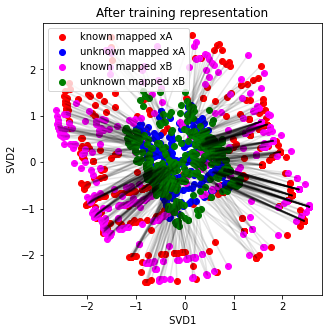

In [96]:
# Debugging to see where the embedding are positioned in the latent space
rep_known_val_o = known_features_encoder(torch.Tensor(Df_holdout_orig.iloc[:, :mpfeatures].values).to(device))
rep_unknown_val_o = unknown_features_encoder_orig(
    torch.Tensor(Df_holdout_orig.iloc[:, mpfeatures:-1].values).to(device))
# rep_unknown_val_o_from_r = unknown_features_encoder_r(
#     torch.Tensor(Df_holdout_orig0.reindex(columns=reordered_column_names_r).iloc[:, mpfeatures:-1].values).to(
#         device))

rep_known_val_r = known_features_encoder(torch.Tensor(DF_holdout_r.iloc[:, :mpfeatures].values).to(device))
rep_unknown_val_r = unknown_features_encoder_r(
    torch.Tensor(DF_holdout_r.iloc[:, mpfeatures:-1].values).to(device))

## checking for the modality gap of two databases on the same plot
# #breakpoint()
points_to_plot = 500  # len(rep_known_val_o.cpu().detach().numpy())
features_2d_o = svd(np.concatenate([rep_known_val_o.cpu().detach().numpy()[:points_to_plot],
                                    rep_unknown_val_o.cpu().detach().numpy()[:points_to_plot]], 0))
features_2d_r = svd(np.concatenate([rep_known_val_r.cpu().detach().numpy()[:points_to_plot],
                                    rep_unknown_val_r.cpu().detach().numpy()[:points_to_plot]], 0))

plt.figure(figsize=(5, 5))
plt.scatter(features_2d_o[:-points_to_plot, 0], features_2d_o[:-points_to_plot, 1], label='known mapped xA',  c='red')  # known mapped
plt.scatter(features_2d_o[-points_to_plot:, 0], features_2d_o[-points_to_plot:, 1], label='unknown mapped xA', c='blue')  # unknown x1
plt.scatter(features_2d_r[:-points_to_plot, 0], features_2d_r[:-points_to_plot, 1], label='known mapped xB', c='magenta')  # known mapped
plt.scatter(features_2d_r[-points_to_plot:, 0], features_2d_r[-points_to_plot:, 1], label='unknown mapped xB', c='green')  # unknown x2
# connect the dots
for i in range(points_to_plot):
    plt.plot([features_2d_o[i, 0], features_2d_o[points_to_plot + i, 0]],
             [features_2d_o[i, 1], features_2d_o[points_to_plot + i, 1]], c='black', alpha=0.1)
    plt.plot([features_2d_r[i, 0], features_2d_r[points_to_plot + i, 0]],
             [features_2d_r[i, 1], features_2d_r[points_to_plot + i, 1]], c='black', alpha=0.1)
plt.xlabel(" SVD1 ")
plt.ylabel(" SVD2 ")
plt.title("After training representation")
plt.legend()
plt.show()

In [90]:
plt.savefig(
    saving_dir +  "/After_training_Comp_ModalityGapSVD_Dataset_" + str(dataset) + "X_o_dim_" + str(
        encKnwMapWidthFinal) + "_tau_" + str(tau) + "_mapped_features_" + str(mpfeatures) + "_#datapoints_" + str(
        points_to_plot) + "_epochs_" + str(epochs) +  ".png")
plt.savefig(
    saving_dir + "/After_training_Comp_ModalityGapSVD_Dataset_" + str(dataset) + "X_o_dim_" + str(
        encKnwMapWidthFinal) + "_tau_" + str(tau) + "_mapped_features_" + str(mpfeatures) + "_#datapoints_" + str(
        points_to_plot) + "_epochs_" + str(epochs) +  ".pdf")
plt.close()

### Objective matching evaluation using number of mistakes

In [91]:
for param in unknown_features_encoder_orig.parameters(): param.requires_grad = False
temp_input = torch.Tensor(Df_holdout_orig.iloc[:, mpfeatures:-1].values).to(device)
grad_sum_unkn_o = torch.zeros((encUknwD1OrigWidthFinal, temp_input.shape[-1])).to(device)
for i in range(temp_input.shape[0]):
  grad_sum_unkn_o += torch.autograd.functional.jacobian(unknown_features_encoder_orig, temp_input[i])

grad_sum_unkn_o = grad_sum_unkn_o / temp_input.shape[0]

for param in unknown_features_encoder_r.parameters(): param.requires_grad = False
temp_input = torch.Tensor(DF_holdout_r.iloc[:, mpfeatures:-1].values).to(device)
grad_sum_unkn_r = torch.zeros((encUknwD2ReWidthFinal, temp_input.shape[-1])).to(device)
for i in range(temp_input.shape[0]):
  grad_sum_unkn_r += torch.autograd.functional.jacobian(unknown_features_encoder_r, temp_input[i])

grad_sum_unkn_r = grad_sum_unkn_r / temp_input.shape[0]

o_to_r_sim = pairwise.cosine_similarity(np.transpose(grad_sum_unkn_o.cpu().detach().numpy()),
                                        np.transpose(grad_sum_unkn_r.cpu().detach().numpy()), dense_output=True)
r_to_o_sim = pairwise.cosine_similarity(np.transpose(grad_sum_unkn_r.cpu().detach().numpy()),
                                        np.transpose(grad_sum_unkn_o.cpu().detach().numpy()), dense_output=True)

Mistakes_X1_te, Mistakes_X2_te, x1_match_matrix_test, x2_match_matrix_test = Stable_matching_algorithm(
  o_to_r_sim,
  r_to_o_sim,
  index_for_mapping_orig_to_rename[len(mapped_features):],
  index_for_mapping_rename_to_orig[len(mapped_features):],
  len(mapped_features))

print("\n \n List of mismatched feature number when # of mapped features are ", mpfeatures, "\n ")

MisF_X1_te = [reordered_column_names_r[i - 1] for i in Mistakes_X1_te]
MisF_X2_te = [reordered_column_names_orig[i - 1] for i in Mistakes_X2_te]

print(" CL  X1_train mistakes", MisF_X1_te)
print(" CL  X2_train mistakes", MisF_X2_te)

print(" CL  X1_train mistakes (len) ", len(MisF_X1_te), " out of ", num_NonCat_features_orig - mpfeatures)
print(" CL  X2_train mistakes (len) ", len(MisF_X2_te), " out of ", num_NonCat_features_r - mpfeatures)


 ------- Matching from X1_train  --------- 

{R1: C53, R2: C8, R3: C46, R4: C32, R5: C24, R6: C48, R7: C41, R8: C7, R9: C36, R10: C43, R11: C28, R12: C5, R13: C49, R14: C52, R15: C30, R16: C45, R17: C38, R18: C22, R19: C27, R20: C21, R21: C23, R22: C29, R23: C1, R24: C13, R25: C54, R26: C51, R27: C9, R28: C42, R29: C6, R30: C18, R31: C16, R32: C33, R33: C34, R34: C12, R35: C39, R36: C55, R37: C20, R38: C44, R39: C40, R40: C14, R41: C37, R42: C50, R43: C3, R44: C47, R45: C2, R46: C10, R47: C35, R48: C31, R49: C17, R50: C4, R51: C25, R52: C15, R53: C11, R54: C26, R55: C19}

 ------- Matching from X2_train  --------- 

{R1: C23, R2: C45, R3: C43, R4: C50, R5: C12, R6: C29, R7: C8, R8: C2, R9: C27, R10: C46, R11: C53, R12: C34, R13: C24, R14: C40, R15: C52, R16: C31, R17: C49, R18: C30, R19: C55, R20: C37, R21: C20, R22: C18, R23: C21, R24: C5, R25: C51, R26: C54, R27: C19, R28: C11, R29: C22, R30: C15, R31: C48, R32: C4, R33: C32, R34: C33, R35: C47, R36: C9, R37: C41, R38: C17, R39: C35

### Objective matching evaluation using F1 score

In [92]:
# taking only the unmapped part of the permutation matrix
P_x1_small = P_x1[len(mapped_features):-1, len(mapped_features):-1]


TP_x1 = 0
FP_x1 = 0
TN_x1 = 0
FN_x1 = 0
for i in range(P_x1_small.shape[0]):
  for j in range(P_x1_small.shape[1]):
    if (P_x1_small[i, j] == 1) & (x1_match_matrix_test[i, j] == 1):
      TP_x1 = TP_x1 + 1
    elif (P_x1_small[i, j] == 1) & (x1_match_matrix_test[i, j] == 0):
      FN_x1 = FN_x1 + 1
    elif (P_x1_small[i, j] == 0) & (x1_match_matrix_test[i, j] == 0):
      TN_x1 = TN_x1 + 1
    elif (P_x1_small[i, j] == 0) & (x1_match_matrix_test[i, j] == 1):
      FP_x1 = FP_x1 + 1

TP_x2 = 0
FP_x2 = 0
TN_x2 = 0
FN_x2 = 0
for i in range(P_x1_small.shape[0]):
  for j in range(P_x1_small.shape[1]):
    if (P_x1_small[i, j] == 1) & (x2_match_matrix_test[i, j] == 1):
      TP_x2 = TP_x2 + 1
    elif (P_x1_small[i, j] == 1) & (x2_match_matrix_test[i, j] == 0):
      FN_x2 = FN_x2 + 1
    elif (P_x1_small[i, j] == 0) & (x2_match_matrix_test[i, j] == 0):
      TN_x2 = TN_x2 + 1
    elif (P_x1_small[i, j] == 0) & (x2_match_matrix_test[i, j] == 1):
      FP_x2 = FP_x2 + 1

F1_fromx1 = (2 * TP_x1) / (2 * TP_x1 + FN_x1 + FP_x1)
F1_fromx2 = (2 * TP_x2) / (2 * TP_x2 + FN_x2 + FP_x2)


print(" F1 score using CL: ", F1_fromx1)

 F1 score using CL:  0.4727272727272727


### Subjective matching evaluation using MSE score

In [93]:
to_map_orig = reordered_column_names_orig[-(num_NonCat_features_orig - mpfeatures + 1):-1]
to_map_r = reordered_column_names_r[-(num_NonCat_features_r - mpfeatures + 1):-1]

predmapped_orig_r = []
for i in range(x1_match_matrix_test.shape[0]):
    for j in range(x1_match_matrix_test.shape[1]):
        if x1_match_matrix_test[i, j] == 1:
            predmapped_orig_r.append(to_map_r[j])

predicted_match_dic_x1 = dict(zip(to_map_orig, predmapped_orig_r))


true_match_list = ['Col' + str(i + 1) for i in range(num_NonCat_features_orig)]
match_dict = dict(zip(true_match_list, true_match_list))

# breakpoint()
final_dic_for_compar_matching = {}
for key, val in match_dict.items():
    if val in predicted_match_dic_x1.values():
        final_dic_for_compar_matching[key] = list(predicted_match_dic_x1.keys())[list(predicted_match_dic_x1.values()).index(val)]

overall_quality_error_matching_only = mean_squared_error(Df_holdout_orig[final_dic_for_compar_matching.keys()].values,Df_holdout_orig[final_dic_for_compar_matching.values()])


In [94]:
predicted_match_dic_x1

{'Col1': 'Col1',
 'Col2': 'Col2',
 'Col5': 'Col5',
 'Col6': 'Col6',
 'Col7': 'Col24',
 'Col8': 'Col20',
 'Col9': 'Col9',
 'Col10': 'Col10',
 'Col11': 'Col19',
 'Col12': 'Col11',
 'Col13': 'Col13',
 'Col14': 'Col15',
 'Col15': 'Col14',
 'Col18': 'Col18',
 'Col19': 'Col12',
 'Col20': 'Col23',
 'Col21': 'Col21',
 'Col22': 'Col7',
 'Col23': 'Col8',
 'Col24': 'Col22',
 'Col25': 'Col25',
 'Col26': 'Col26',
 'Col27': 'Col28',
 'Col28': 'Col27',
 'Col29': 'Col29',
 'Col30': 'Col30',
 'Col31': 'Col32',
 'Col32': 'Col35',
 'Col34': 'Col36',
 'Col35': 'Col31',
 'Col36': 'Col34',
 'Col37': 'Col37',
 'Col38': 'Col41',
 'Col39': 'Col38',
 'Col40': 'Col40',
 'Col41': 'Col39',
 'Col42': 'Col42',
 'Col43': 'Col43',
 'Col44': 'Col44',
 'Col46': 'Col48',
 'Col47': 'Col47',
 'Col48': 'Col46',
 'Col49': 'Col61',
 'Col50': 'Col53',
 'Col51': 'Col51',
 'Col52': 'Col52',
 'Col53': 'Col50',
 'Col54': 'Col54',
 'Col55': 'Col62',
 'Col56': 'Col56',
 'Col57': 'Col57',
 'Col59': 'Col59',
 'Col60': 'Col60',
 'Col61